In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import imageio.v2 as imageio
from tqdm import tqdm

%matplotlib inline

In [2]:
t = .1
dt = 0.01
sigma = 5.
min_val = -6
max_val = 6

In [3]:
def calc_logsumexp(x, denom):
    return torch.exp(x - torch.logsumexp(denom, dim=0))


def uncond_score(x, t, m1, m2, Gamma_t, label=None, omega=None):
    exp_neg_t = torch.exp(-t)
    exp_neg_m1m2 = torch.exp(-m1 * m2 * exp_neg_t**2 / Gamma_t)
    exp_pos_m1m2 = torch.exp(m1 * m2 * exp_neg_t**2 / Gamma_t)
    x_dot_m1_plus_m2 = torch.dot(x, (m1 + m2))
    x_dot_m1_minus_m2 = torch.dot(x, (m1 - m2))

    arg1 = torch.log(exp_neg_m1m2) + x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg2 = torch.log(exp_neg_m1m2) - x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg3 = torch.log(exp_pos_m1m2) + x_dot_m1_minus_m2 * exp_neg_t / Gamma_t
    arg4 = torch.log(exp_pos_m1m2) - x_dot_m1_minus_m2 * exp_neg_t / Gamma_t

    denom = torch.stack([arg1, arg2, arg3, arg4], dim=0)
    l11 = (m1 + m2) * calc_logsumexp(arg1, denom)
    l12 = -(m1 + m2) * calc_logsumexp(arg2, denom)
    l21 = (m1 - m2) * calc_logsumexp(arg3, denom)
    l22 = - (m1 - m2) * calc_logsumexp(arg4, denom)

    S_i_t = (-x / Gamma_t) + (exp_neg_t / Gamma_t) * (l11 + l12 + l21 + l22)
    return S_i_t


def cond_score(x, t, m1, m2, Gamma_t, label=0, omega=None):
    score = (-x + ((2*(label < 2)-1) * m1 + (2*(label % 2)-1) * m2)
             * torch.exp(-t)) / Gamma_t
    return score


def cfg(x, t, m1, m2, Gamma_t, omega, label=0):
    uncond_score_ = uncond_score(x, t, m1, m2, Gamma_t, label)
    cond_score_ = cond_score(x, t, m1, m2, Gamma_t, label)
    return (1+omega) * cond_score_ - omega * uncond_score_

In [4]:
def kl_div(sample1, sample2):
    mean1, std1 = sample1.mean(dim=0), sample1.std(dim=0)
    mean2, std2 = sample2.mean(dim=0), sample2.std(dim=0)

    var1, var2 = torch.pow(std1, 2), torch.pow(std2, 2)
    kl = 0.5 * torch.sum(torch.pow(mean1 - mean2, 2) / var2 +
                         var1 / var2 - 1.0 - torch.log10(var1) + torch.log10(var2))
    return kl.sum()

# 2d

In [6]:
d = 2

# sample from standard d-dimensional gaussian
init_samples = torch.randn(1000, d)

# sample from a mixture 
m1_ = torch.tensor([5., 0.])
m2_ = torch.tensor([0., 5.])
means = torch.cat((torch.stack([m1_+m2_, m1_-m2_,-m1_+m2_,-m1_-m2_]), torch.zeros((4, d-2))), axis=1)
cov = torch.eye(d) * sigma
weight = torch.tensor(1/len(means))
num_samples = 200
samples = []
for mean in means:
    num_samples_gaussian = int(num_samples * weight)
    distribution = torch.distributions.MultivariateNormal(mean, cov)
    samples_gaussian = distribution.sample((num_samples_gaussian,))
    samples.append(samples_gaussian)

data_samples = torch.cat(samples)

# Define the mean vector
mean_vector = torch.cat((m1_-m2_, torch.zeros(d-2)), axis=0)
cov_matrix = torch.eye(d) * sigma
distribution = torch.distributions.MultivariateNormal(mean_vector, cov_matrix)

# Sample from the distribution
target_sample = distribution.sample((num_samples,))

(-8.0, 8.0)

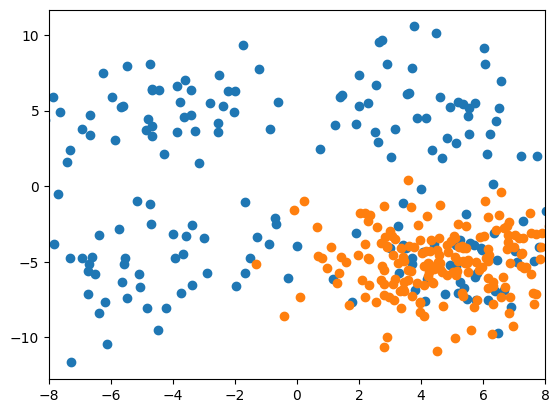

In [7]:
plt.scatter(*data_samples.T, )
plt.scatter(*target_sample.T)
plt.xlim(-8,8)

In [11]:
omega = 25.
dt = 0.05
finish_time = 4.
m1, m2 = torch.cat((torch.stack([m1_, m2_]), torch.zeros((2, d-2))), axis=1)

images_new, x_prev, kls, js = [], init_samples, [], []

timesteps = torch.tensor(np.arange(0, finish_time+dt, dt))
for t in tqdm(timesteps):
    t_end = torch.tensor(finish_time)
    x_cur = []
    
    for x in x_prev:
        Gamma_t = sigma**2*torch.exp(-2*(t_end-t)) + dt
        score_un = uncond_score(x, t_end-t, m1, m2, Gamma_t)
        score_c = cond_score(x, t_end-t, m1, m2, Gamma_t, label=0)
        # score = cfg(x, t_end-t, m1, m2, Gamma_t, omega=omega, label=0)
        score = score_c+ (score_c-score_un)*(torch.abs(score_c-score_un))**0.5
        eta = torch.randn_like(x) * torch.sqrt(torch.tensor(2*dt))
        x_new = x + 2 * dt * score + eta
        x_cur.append(x_new)
    x_cur = torch.stack(x_cur)
    kls.append(kl_div(x_cur, target_sample))
    js.append(1/2*(kl_div(x_cur, target_sample) + kl_div(target_sample, x_cur)))
    x_prev = x_cur

100%|██████████| 81/81 [00:39<00:00,  2.04it/s]


(-6.0, 6.0)

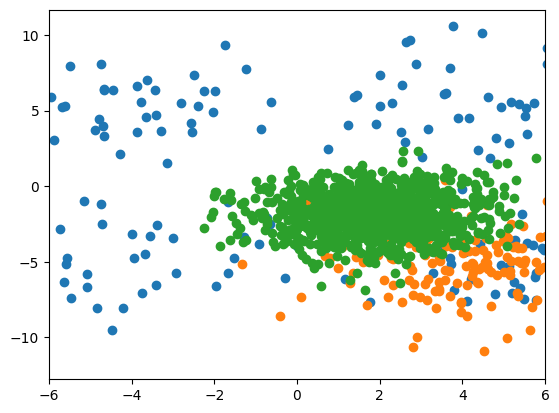

In [12]:
plt.scatter(*data_samples.T, )
plt.scatter(*target_sample.T)
plt.scatter(*x_cur.T)
plt.xlim(-6,6)

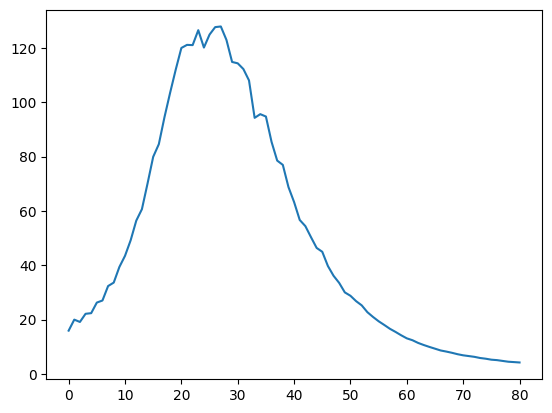

In [13]:
plt.plot(js)

# 3d

In [48]:
d = 3


# sample from standard d-dimensional gaussian
init_samples = torch.randn(1000, d)

# sample from a mixture 
m1_ = torch.tensor([4, 4., 0])
m2_ = torch.tensor([0., 0., 4.])
means = torch.cat((torch.stack([m1_+m2_, m1_-m2_,-m1_+m2_,-m1_-m2_]), torch.zeros((4, d-3))), axis=1)
cov = torch.eye(d) * sigma
weight = torch.tensor(1/len(means))
num_samples = 200
samples = []
for mean in means:
    num_samples_gaussian = int(num_samples * weight)
    distribution = torch.distributions.MultivariateNormal(mean, cov)
    samples_gaussian = distribution.sample((num_samples_gaussian,))
    samples.append(samples_gaussian)

data_samples = torch.cat(samples)

In [91]:
# Define the mean vector
mean_vector = torch.cat((m1_-m2_, torch.zeros(d-3)), axis=0)
cov_matrix = torch.eye(d)
distribution = torch.distributions.MultivariateNormal(mean_vector, cov_matrix)

# Sample from the distribution
target_sample = distribution.sample((num_samples,))

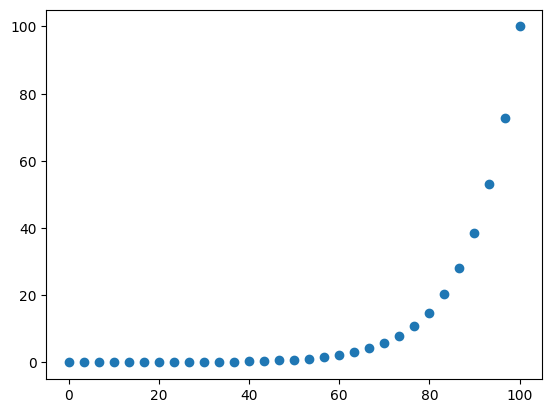

In [74]:
plt.scatter(torch.linspace(0,100,31), torch.cat((torch.zeros(1), torch.logspace(-2, 2, 30, base=10, dtype=None, device=None, requires_grad=False))).numpy())

In [ ]:
sigma = 3.
omega = .1
dt = 0.1
finish_time = 4.
m1, m2 = torch.cat((torch.stack([m1_, m2_]), torch.zeros((2, d-3))), axis=1)

images_new, x_prev, kls, js = [], init_samples, [], []

timesteps = torch.tensor(np.arange(0, finish_time+dt, dt))
for t in tqdm(timesteps):
    t_end = torch.tensor(finish_time)
    x_cur = []
    
    for x in x_prev:
        Gamma_t = sigma**2*torch.exp(-2*(t_end-t)) + dt
        # score = uncond_score(x, t_end-t, m1, m2, Gamma_t)
        # score = cond_score(x, t_end-t, m1, m2, Gamma_t, label=0)
        score = cfg(x, t_end-t, m1, m2, Gamma_t, omega=omega, label=0)
        eta = torch.randn_like(x) * torch.sqrt(torch.tensor(2*dt))
        x_new = x + 2 * dt * score + eta
        x_cur.append(x_new)
    x_cur = torch.stack(x_cur)
    kls.append(kl_div(x_cur, target_sample))
    js.append(1/2*(kl_div(x_cur, target_sample) + kl_div(target_sample, x_cur)))
    x_prev = x_cur

100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


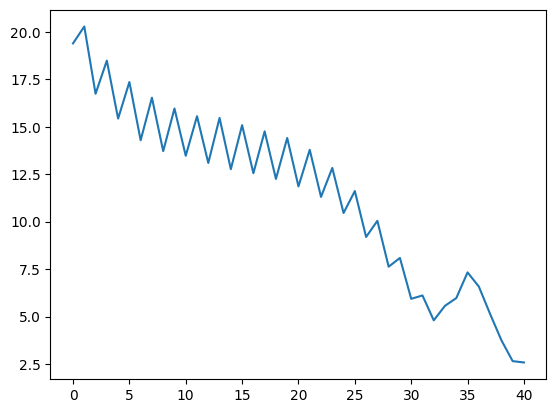

In [99]:
plt.plot(js)

# deleteme

In [1]:
import numpy as np
import wandb
import submitit
import argparse
import itertools
import random
import torch
import os

import torch
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from warnings import simplefilter


def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.


# ignore all warnings
simplefilter(action='ignore')
def get_job_id():
    if "SLURM_ARRAY_JOB_ID" in os.environ:
        return os.environ["SLURM_ARRAY_JOB_ID"] + "_" + os.environ["SLURM_ARRAY_TASK_ID"]
    if "SLURM_JOB_ID" in os.environ:
        return os.environ["SLURM_JOB_ID"]
    return None



def calc_logsumexp(x, denom):
    return torch.exp(x - torch.logsumexp(denom, dim=0))

def uncond_score(x, t, m1, m2, Gamma_t, label=None, omega=None):
    exp_neg_t = torch.exp(-t)
    exp_neg_m1m2 = torch.exp(-m1 * m2 * exp_neg_t**2 / Gamma_t)
    exp_pos_m1m2 = torch.exp(m1 * m2 * exp_neg_t**2 / Gamma_t)
    x_dot_m1_plus_m2 = torch.dot(x, (m1 + m2))
    x_dot_m1_minus_m2 = torch.dot(x, (m1 - m2))

    arg1 = torch.log(exp_neg_m1m2) + x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg2 = torch.log(exp_neg_m1m2) - x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg3 = torch.log(exp_pos_m1m2) + x_dot_m1_minus_m2 * exp_neg_t / Gamma_t
    arg4 = torch.log(exp_pos_m1m2) - x_dot_m1_minus_m2 * exp_neg_t / Gamma_t

    denom = torch.stack([arg1, arg2, arg3, arg4], dim=0)
    l11 = (m1 + m2) * calc_logsumexp(arg1, denom)
    l12 = -(m1 + m2) * calc_logsumexp(arg2, denom)
    l21 = (m1 - m2) * calc_logsumexp(arg3, denom)
    l22 = - (m1 - m2) * calc_logsumexp(arg4, denom)

    S_i_t = (-x / Gamma_t) + (exp_neg_t / Gamma_t) * (l11 + l12 + l21 + l22)
    return S_i_t

def cond_score(x, t, m1, m2, Gamma_t, label=0, omega=None):
    score = (-x +((2*(label<2)-1) * m1 + (2*(label%2)-1) * m2) * torch.exp(-t)) / Gamma_t
    return score

def cfg(x, t, m1, m2, Gamma_t, omega, label=0):
    uncond_score_ = uncond_score(x, t, m1, m2, Gamma_t, label)
    cond_score_ = cond_score(x, t, m1, m2, Gamma_t, label)
    return (1+omega) * cond_score_ - omega * uncond_score_


def get_vf(m1, m2, score_func, t, dt, sigma, n=10, min=-5, max=5, label=0, plot=False, omega=None):
    t, sigma = torch.tensor(t), torch.tensor(sigma)
    Gamma_t = sigma**2*torch.exp(-2*t) + dt

    xx, yy = torch.meshgrid(
    [torch.linspace(min, max, steps=n)]*2, indexing='ij')
    inp = torch.stack((xx, yy), dim=-1).reshape(-1, 2)

    conc = []
    for inp_ in inp:
        conc.append(score_func(inp_, t, m1, m2, Gamma_t, label=label, omega=omega))

    conc = torch.stack(conc).reshape(n, n, 2).detach().numpy()
    inp = inp.reshape(n, n, 2).detach().numpy()
    
    if plot:
        plt.figure(figsize=(8, 8))
        plt.quiver(inp[:,:,0],inp[:,:,1],conc[:,:,0],conc[:,:,1])
        for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
            plt.scatter(plots[0], plots[1], color='r', s=100)
        plt.show()
    return inp, conc

def kl_div(sample1, sample2):
    mean1, std1 = sample1.mean(dim=0), sample1.std(dim=0)
    mean2, std2 = sample2.mean(dim=0), sample2.std(dim=0)

    var1, var2 = torch.pow(std1, 2), torch.pow(std2, 2)
    kl = 0.5 * torch.sum(torch.pow(mean1 - mean2, 2) / var2 +
                         var1 / var2 - 1.0 - torch.log10(var1) + torch.log10(var2))
    return kl.sum()

In [2]:
sigma = 1.
alpha = -0.5

In [3]:
m1 = torch.tensor([5.,0.])
m2 = torch.tensor([0., 5])
dt = 0.01
finish_time = 4.

num_samples = 200
mean, cov = torch.tensor([0., 0.]), torch.tensor([[1., 0.], [0., 1.]])
distribution = torch.distributions.MultivariateNormal(mean, cov)
all_samples = distribution.sample((num_samples,))


In [ ]:
impo

In [22]:
from tqdm import tqdm
x_prev = all_samples

# Define the mean vector
mean_vector = m1-m2
cov_matrix = torch.eye(2) * sigma
distribution = torch.distributions.MultivariateNormal(mean_vector, cov_matrix)

# Sample from the distribution
target_sample = distribution.sample((num_samples,))

timesteps = torch.tensor(np.arange(0, finish_time+dt, dt))
for t in tqdm(timesteps):
    t_end = torch.tensor(finish_time)
    x_cur = []
    
    for x in x_prev:
        Gamma_t = sigma**2*torch.exp(-2*(t_end-t)) + dt
        score_un = uncond_score(x, t_end-t, m1, m2, Gamma_t)
        score_c = cond_score(x, t_end-t, m1, m2, Gamma_t, label=0)
        # score = cfg(x, t_end-t, m1, m2, Gamma_t, omega=omega, label=0)
        if alpha!=0:
            score = score_c+ (score_c-score_un)*torch.clip((torch.abs(score_c-score_un))**alpha, max=2)
        else:
            score = score_c + 25 * (score_c-score_un)
        eta = torch.randn_like(x) * torch.sqrt(torch.tensor(2*dt))
        x_new = x + 2 * dt * score + eta
        x_cur.append(x_new)

    x_cur = torch.stack(x_cur)
    x_prev = x_cur
    
    kl_for = kl_div(x_cur, target_sample)
    kl_back = kl_div(target_sample, x_cur)
    js = (kl_for + kl_back) / 2

  0%|          | 1/401 [00:00<00:46,  8.62it/s]

100%|██████████| 401/401 [00:44<00:00,  9.07it/s]
